# Classification - Multi-Layer Case(For Mnist)

# Library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("device: gpu") if torch.cuda.is_available() else print("device: cpu")

device: gpu


# Hyper parameter setting

In [2]:
# hypter parameter setting
learning_rate = 1e-1
epochs = 25
# batch_size = 60000 # gradient descent
# batch_size = 1 # stochastic gradient descent
batch_size = 32 # mini-batch stochastic gradient descent
act = nn.ReLU()
h = 200 #hidden layer
display_step = 5

# Load data and pre-process data 

len(train_data):  60000
len(test_data):  10000
original data shape:  torch.Size([1, 28, 28])
label:  5


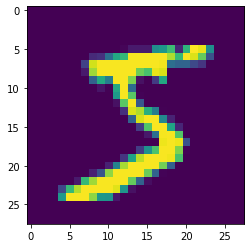

processed data shape: torch.Size([32, 1, 28, 28])
label: tensor([9, 9, 9, 7, 8, 6, 5, 0, 3, 1, 2, 4, 4, 9, 0, 5, 0, 7, 2, 4, 4, 2, 6, 5,
        4, 7, 3, 1, 1, 9, 7, 9])


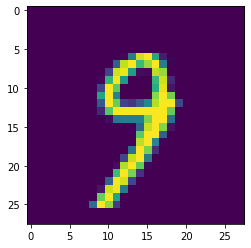

In [3]:
# load data
train_data = dataset.MNIST("./", train = True, transform = transforms.ToTensor(), target_transform = None, download = True)
test_data = dataset.MNIST("./", train = False, transform = transforms.ToTensor(), target_transform = None, download = True)

# check the data
print('len(train_data): ', len(train_data))
print('len(test_data): ', len(test_data))

x_train, y_train = train_data[0]
print('original data shape: ', x_train.shape)
print('label: ', y_train)

plt.figure()
plt.imshow(x_train[0])
plt.show()

# Pre-process (batch, shuffle)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1000, shuffle = True, num_workers = 1, drop_last = True)

# check the data 
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print('processed data shape:', example_data.shape)
print('label:', example_target)

plt.figure()
plt.imshow(example_data[0][0])
plt.show()

# Multi Layer Classification

## Train and result (with mini-batch stochastic gradient descent)

In [4]:
print(x_train.shape,x_train.shape[1:])

# model
model = nn.Sequential(
        nn.Linear(np.prod(x_train.shape[1:]),h), #np.prod 곱해주는거
        act,
        nn.Linear(h,10),
        )

model = model.to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

loss_array = []
iteration_loss_array = []

# train the model
for epoch in range(epochs):
    for iteration, [data, label] in enumerate(train_loader):
        optimizer.zero_grad()
        
        x = data.to(device)
        x = x.view(batch_size, -1)
        y = label.to(device)
        
        output = model(x)

        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()
        iteration_loss_array.append(loss.cpu().detach().numpy())
            
    loss_array.append(loss.cpu().detach().numpy())
    
    if epoch % 5 == 0:
        print("Epoch:", epoch + 1, "\Loss:", loss)

torch.Size([1, 28, 28]) torch.Size([28, 28])
Epoch: 1 \Loss: tensor(0.1529, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 6 \Loss: tensor(0.0941, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 11 \Loss: tensor(0.0156, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 16 \Loss: tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 21 \Loss: tensor(0.0027, device='cuda:0', grad_fn=<NllLossBackward>)


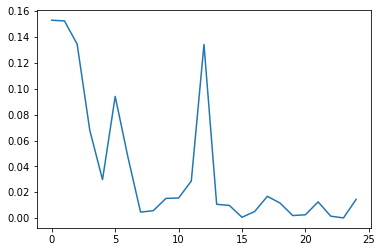

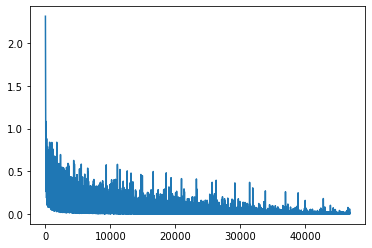

In [5]:
# plot losses
plt.figure()
plt.plot(loss_array)
plt.show()
# plot iteration losses
plt.figure()
plt.plot(iteration_loss_array)
plt.show()

In [6]:
# test
model.eval()
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 10000, shuffle = True, num_workers = 1, drop_last = True)
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

total 10000
correct tensor(9821., device='cuda:0')
accuracy tensor(0.9821, device='cuda:0')


In [7]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

prediction : (10000,)
true label : (10000,)


array([[ 970,    0,    1,    0,    0,    0,    3,    1,    3,    2],
       [   0, 1125,    3,    1,    0,    1,    2,    1,    2,    0],
       [   3,    1, 1010,    2,    3,    0,    2,    4,    7,    0],
       [   0,    0,    3,  990,    0,    3,    0,    2,    4,    8],
       [   0,    0,    2,    1,  965,    0,    4,    2,    0,    8],
       [   2,    0,    0,    9,    1,  871,    3,    0,    5,    1],
       [   4,    2,    2,    1,    5,    3,  940,    0,    1,    0],
       [   0,    4,    7,    3,    0,    0,    0, 1009,    1,    4],
       [   2,    0,    1,    4,    3,    0,    2,    2,  957,    3],
       [   3,    2,    0,    4,   10,    1,    0,    5,    0,  984]])

## Advanced: Weight initialization

In [8]:
def init_weights(m): # xavier 초기화
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


# model
model = nn.Sequential(
        nn.Linear(np.prod(x_train.shape[1:]),h),
        act,
        nn.Linear(h,10),
        )
model.apply(init_weights)
model = model.to(device)
model.train()


# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

loss_array = []
iteration_loss_array = []

# train the model
for epoch in range(epochs):
    for iteration, [data, label] in enumerate(train_loader):
        optimizer.zero_grad()
        
        x = data.to(device)
        x = x.view(batch_size, -1)
        y = label.to(device)
        
        output = model(x)

        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()
        iteration_loss_array.append(loss.cpu().detach().numpy())
            
    loss_array.append(loss.cpu().detach().numpy())
    
    if epoch % 5 == 0:
        print("Epoch:", epoch + 1, "\Loss:", loss)

/home/piai/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 1 \Loss: tensor(0.2870, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 6 \Loss: tensor(0.0176, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 11 \Loss: tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 16 \Loss: tensor(0.0110, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 21 \Loss: tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward>)


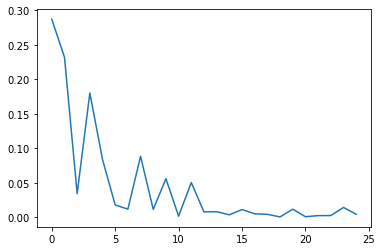

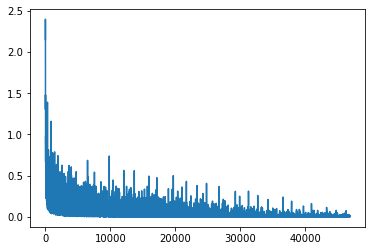

In [9]:
# plot losses
plt.figure()
plt.plot(loss_array)
plt.show()
# plot iteration losses
plt.figure()
plt.plot(iteration_loss_array)
plt.show()

In [10]:
# test
model.eval()
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 10000, shuffle = True, num_workers = 1, drop_last = True)
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
    
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

total 10000
correct tensor(9813., device='cuda:0')
accuracy tensor(0.9813, device='cuda:0')


In [11]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

prediction : (10000,)
true label : (10000,)


array([[ 971,    1,    1,    0,    1,    0,    3,    0,    2,    1],
       [   0, 1125,    3,    1,    0,    0,    2,    2,    2,    0],
       [   3,    2, 1010,    3,    1,    0,    2,    5,    6,    0],
       [   0,    0,    2,  994,    0,    4,    0,    4,    2,    4],
       [   1,    0,    1,    0,  967,    0,    4,    1,    0,    8],
       [   2,    0,    0,    8,    2,  868,    3,    1,    6,    2],
       [   3,    3,    0,    1,    3,    3,  943,    0,    2,    0],
       [   0,    4,    6,    1,    0,    0,    0, 1009,    3,    5],
       [   4,    0,    3,    4,    4,    2,    2,    2,  949,    4],
       [   2,    3,    0,    4,    7,    5,    1,    4,    6,  977]])